# Pipeline

imports

In [140]:
import json
import os
import csv
import time
import numpy as np
import datetime
import random
import shutil
# from scipy.stats import norm
from itertools import product 
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# import yaml
# from ruamel.yaml import YAML

In [141]:
import sys
print(sys.path)
src_path = os.path.join(os.getcwd(), 'src')
sys.path.append(src_path)
# print(src_path)

['/opt/homebrew/Caskroom/miniconda/base/envs/robustness/lib/python39.zip', '/opt/homebrew/Caskroom/miniconda/base/envs/robustness/lib/python3.9', '/opt/homebrew/Caskroom/miniconda/base/envs/robustness/lib/python3.9/lib-dynload', '', '/opt/homebrew/Caskroom/miniconda/base/envs/robustness/lib/python3.9/site-packages', '/Users/I583318/Library/CloudStorage/OneDrive-SAPSE/Development/phd/robustness/src', '/opt/homebrew/Caskroom/miniconda/base/envs/robustness/lib/python3.9/site-packages/setuptools/_vendor', '/opt/gurobi201/linux32/lib/python2.5', '/Users/I583318/Library/CloudStorage/OneDrive-SAPSE/Development/phd/robustness/src', '/Users/I583318/Library/CloudStorage/OneDrive-SAPSE/Development/phd/robustness/src']


In [142]:
# Enable autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [143]:
# from src.utils import LogColumnNames
from src.log_stats_calculation import *
from src.simulators.param_manipulation import *
from src.sim_execution_and_evalaution import *
from src.logging import log_simulation, initialize_simulation_log, save_params, set_up_experiment_output_dir, save_simulation_log
from src.search_strategies.grid_search import run_grid_search
from src.simulators.simod_discovery import discover_BPS_simod
# from src.logging import *

In [144]:
from prosimos import simulation_engine, simulation_properties_parser
# from simod.simod import Simod
# from simod.event_log.event_log import EventLog
# from simod.settings.simod_settings import SimodSettings
from simod.simulation.prosimos import *


# Pipeline

## 0. Input

In [145]:
# - event_log: historical process data
# - target_PPI: performance metric (e.g., cycle time)
# - PPI_target_range: acceptable range (e.g., [0, 5])
# - simulation_tool: engine for discrete-event simulation
# - changeable_parameters_list: list of parameters to vary
# # - simulation_model: built from event_log


# Inputs
# process_name = 'dummy_2tasks'
# process_name = 'LoanApp'
# process_name = 'LoanApp_SingleRole'
process_name = 'LoanApp_SingleRole_fixDuration'
# process_name = 'ten_activities'
# process_name = 'LoanApp_TwoRoles'

# target_ppi = 'cycle_time'
# target_ppi = 'idle_cycle_time'

# target_ppis = ['idle_cycle_time', 'cost']
target_ppis = ['lead_time', 'cost']
# target_ppis = ['lead_time']
# target_ppis = ['cost']

ppi_range_factor = 0.35

cases_to_simulate = 100
discover_bps_model = False
nr_simulations_per_scenario = 1
execute_strategy = ['grid_search', 'quadtree'] # 'hyperquadtree', 'diagonal_search', 'hill_climbing'

confidence = 0.90
calculate_stats = 'custom'  # 'custom' or 'simod'
dt = datetime.datetime(2025, 6, 23, 9, 0, tzinfo=datetime.timezone.utc)
simulation_tool = 'simod'

print_intermediate_results = True

# internal parameters
decimals = 2
# retain_simulation_data = False
simulation_results_confidence = True
in_out_criteria = "confidence"  # "mean" or "confidence"
simod_config_path = 'simulators/simod/resources/config/config_one-shot.yml'
simod_directory = 'simulators/simod'
ppi_calculation = {
    'cost': {
        'type': 'total',
        'method': 'full_duration', # full_duration, active_time, combined
        'weight': 1.5         # only applicable for 'combined' method
    },
    'lead_time': {
        'type': 'avg'}
    }




In [146]:
# Write inputs into 
base_path = os.path.join('data', process_name)

dt_str = dt.strftime("%Y-%m-%dT%H:%M:%SZ")

params = {
    'process_name': process_name,
    'base_path': base_path,
    'target_ppis': target_ppis,
    'ppi_range_factor': ppi_range_factor,
    'cases_to_simulate': cases_to_simulate,
    'starting_at':dt_str,
    'simulation_tool': simulation_tool,
    'nr_simulations_per_scenario': nr_simulations_per_scenario,
    'decimals': decimals,
    'simulation_results_confidence': simulation_results_confidence,
    'calculate_stats': calculate_stats,
    'confidence': confidence,
    'in_out_criteria': in_out_criteria,
    'print_intermediate_results': print_intermediate_results,
    'execute_strategy': execute_strategy,
    'simod_config_path': simod_config_path,
    'simod_directory': simod_directory,
    'ppi_calculation': ppi_calculation
}


results = {}

In [147]:


params['strategies'] = {
    'grid_search': {
        'granularity': 25,
        'input': 'original_input' 
    },
    'hyperquadtree': {
        'min_depth': 2,
        'max_depth': 6
    },
    'quadtree': {
        'min_depth': 2,
        'max_depth': 6
    },
    'diagonal_search': {
        'stepsize_initial': 0.1,
        'step_max': 20,
        'adaptive_step': True,
        'strictness': 0.01
    },
    'hill_climbing': {
        'stepsize_initial': 0.1,
        'step_max': 20,
        # 'adaptive_step': True,
        'candidate_strategy': 'random_one',
        'walk_reps_max': 100
    }
}

In [148]:
# params[cases_to_simulate] = 100
# params['nr_simulations_per_scenario'] = 1
# params['confidence'] = confidence
# params['print_intermediate_results'] = False
# params['target_ppis'] = ['lead_time', 'cost']

# ppi = 'cost'
# metric_type = params['ppi_calculation'][ppi]['type']
# calculation_method = params['ppi_calculation'][ppi]['type']
# metric_type, calculation_method

### 0.5 Discovery

#### implement automatic calling of discovery

In [149]:
# def copy_simod_files(params):
#     """
#     Copies the BPMN and JSON files from the 'best_result' directory to the base directory.

#     Args:
#         params (dict): Dictionary containing configuration parameters, including 'print_intermediate_results'.

#     Returns:
#         None
#     """

#     base_path = params['base_path']
#     process_name = params['process_name']

#     # Define source paths
#     bpmn_src = os.path.join(base_path, 'best_result', process_name + '.bpmn')
#     json_src = os.path.join(base_path, 'best_result', process_name + '.json')

#     # Define destination paths
#     bpmn_dest = os.path.join(base_path, process_name + '.bpmn')
#     json_dest = os.path.join(base_path, process_name + '.json')

#     # Helper function to conditionally print messages
#     def conditional_print(message):
#         if params.get('print_intermediate_results', False):
#             print(message)

#     # Copy the BPMN file
#     try:
#         shutil.copy(bpmn_src, bpmn_dest)
#         conditional_print(f"Copied BPMN file from {bpmn_src} to {bpmn_dest}")
#     except FileNotFoundError:
#         conditional_print(f"Error: BPMN file not found at {bpmn_src}")
#     except Exception as e:
#         conditional_print(f"Error copying BPMN file: {e}")

#     # Copy the JSON file
#     try:
#         shutil.copy(json_src, json_dest)
#         conditional_print(f"Copied JSON file from {json_src} to {json_dest}")
#     except FileNotFoundError:
#         conditional_print(f"Error: JSON file not found at {json_src}")
#     except Exception as e:
#         conditional_print(f"Error copying JSON file: {e}")

In [150]:
if discover_bps_model:

    discover_BPS_simod(params)

    # # Read and update the simod configuration file: set train_log_path
    # update_simod_config_train_path(params)

    # # Specify the path to the simod directory
    # simod_directory = os.path.join('simulators', 'simod')

    # # output = Path(os.path.join(simod_directory, 'resources', 'output'))
    # output = Path(os.path.join(params['base_path']))

    # configuration_path = Path(os.path.join(simod_directory, 'resources', 'config', 'config_one-shot.yml' ))
    # settings = SimodSettings.from_path(configuration_path)

    # # Read and preprocess event log
    # event_log = EventLog.from_path(
    #     log_ids=settings.common.log_ids,
    #     train_log_path=settings.common.train_log_path,
    #     # test_log_path=settings.common.test_log_path,
    #     preprocessing_settings=settings.preprocessing,
    #     need_test_partition=settings.common.perform_final_evaluation,
    # )

    # # Instantiate and run SIMOD
    # simod = Simod(settings=settings, event_log=event_log, output_dir=output)
    # simod.run()

    # # Copy the discovered model to the process data folder
    # copy_simod_files(params)

In [151]:
# reading in of temp BPS_model json file

# dt = datetime.datetime(2025, 6, 23, 9, 0, tzinfo=datetime.timezone.utc)
# dt_str = dt.strftime("%Y-%m-%dT%H:%M:%SZ")

# if discover_bps_model:
#     bpmn_path = os.path.join(base_path, 'best_result', process_name + '.bpmn')
#     json_path = os.path.join(base_path, 'best_result', process_name + '.json')



# else:      
bpmn_path = os.path.join(params['base_path'], params['process_name'] + '.bpmn')
json_path = os.path.join(params['base_path'], params['process_name'] + '.json')


params['json_path'] = json_path
json_path_temp = create_temp_json(input_path=json_path, output_path=None)
params['bpmn_path'] = bpmn_path
params['json_path_temp'] = json_path_temp


##### BPMN plotting

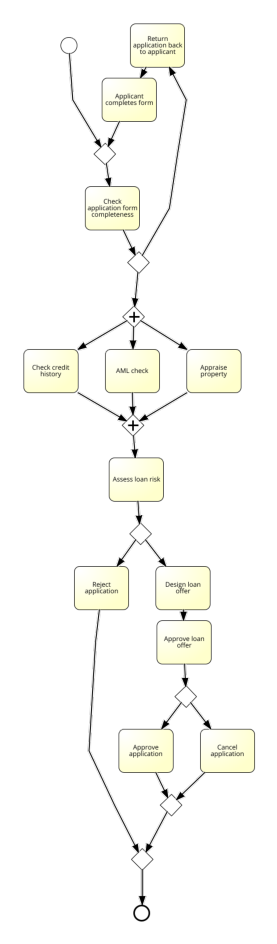

In [152]:

# Specify the path to your PNG file
name = params['process_name']
image_path = os.path.join(params['base_path'],  f'{name}.png')

try:
    # Load and display the image
    img = mpimg.imread(image_path)
    fig = plt.figure(figsize=(12, 12))
    plt.imshow(img)
    plt.axis('off')  # Turn off the axis
    plt.show()
except:
    print(f"Image file not found at {image_path}")

## 1.  Set up

### Required Input

In [153]:

# parameters to change


''''
Possible values: 
    - continous ("cont"),
    - discrete ("disc"), 
    - categorical ("cat").

Define ranges for each parameter:
    - continuous: [min, max]    
    - discrete: [min, max]
    - categorical: [list of possible values]
'''

input_parameters = {
    'arriaval_distr_mean': {
        'type': 'cont',
        'values': [60*5, 60*60*4]  # 5 min to 3 hours
    },  
    'resource_count': {
        'type': 'disc',
        'values': [1, 25],  # 1 to 26 resources
        'ignore': ['applicant']
    }
}

ppi_bounds = {
    'lead_time': 'upper',
    'cost': 'upper'
}


### Adaptation based on input ranges and parameters to change

In [154]:
# Determine which parameter to update
params_to_change = {}

if 'resource_count' in input_parameters:
    update_parameter = 'resource_count'
    sim_params = get_sim_params(params['json_path'])
    params_to_change = set_params_to_change(input_parameters, update_parameter, sim_params) 

    if params['print_intermediate_results']:
        print("\nInput parameters:")  
        print(input_parameters)
        print("Parameters to change:")
        print(params_to_change)
        print()

else:
    params_to_change = input_parameters

# Add params_to_change to params dictionary
params['params_to_change'] = params_to_change

# Initialize a global DataFrame to store simulation logs
simulation_log = initialize_simulation_log(params['params_to_change'])



Input parameters:
{'arriaval_distr_mean': {'type': 'cont', 'values': [300, 14400]}, 'resource_count': {'type': 'disc', 'values': [1, 25], 'ignore': ['applicant']}}
Parameters to change:
{'arriaval_distr_mean': {'type': 'cont', 'values': [300, 14400]}, 'resource_count_UnifiedResourceProfile': {'type': 'disc', 'values': [1, 25]}}



### Set up background

In [155]:
# Set up experiment output directory
params = set_up_experiment_output_dir(params)

Output directory ensured at: data/LoanApp_SingleRole_fixDuration/output/20251110_221801


In [156]:
#######################

# Intermediate output

# Get the initial target PPI value
target_ppi_dict = get_simulation_stats(params)

orig_target_ppi_val_dict = {}
target_range_dict = {}

for ppi in params['target_ppis']:
    target_ppi_list = target_ppi_dict[ppi]
    target_ppi_val = np.mean(target_ppi_list)
    orig_target_ppi_val_dict[ppi] = target_ppi_val
    
    # calculate ppi bounds
    target_range = [np.round(target_ppi_val*(1-params['ppi_range_factor'])), np.round(target_ppi_val*(1+params['ppi_range_factor']))]
    # adjust target range based on ppi_bounds
    if ppi_bounds[ppi]=='upper':
        target_range = [0, target_range[1]]
    elif ppi_bounds[ppi]=='lower':
        target_range = [target_range[0], float('inf')]
    elif ppi_bounds[ppi]=='both':
        pass
    else:
        raise ValueError(f"Unknown ppi_bounds value: {ppi_bounds[ppi]}")
    target_range_dict[ppi] = target_range

params['orig_target_ppi_val_dict'] = orig_target_ppi_val_dict
params['target_range'] = target_range_dict


simulation_log = log_simulation(
    simulation_log=simulation_log,
    algorithm='orig_run',
    params=params,
    target_ppi_dict=target_ppi_dict,
    param_values=get_start_param_settings(params_to_change, params),
)

for ppi in params['target_ppis']:
    print(f'average {ppi}: {orig_target_ppi_val_dict[ppi]}h')
    print(f'range: {target_range_dict[ppi]}h')


average lead_time: 60845.0h
range: [0, 82141.0]h
average cost: 19063.333333333332h
range: [0, 25736.0]h


In [157]:
# # Save paramas to json file in data/process_name/output/params.json
save_params(params)

# Write simulation log to CSV
simulation_log.to_csv(params['simulation_log_path'], index=False)

Parameters saved to data/LoanApp_SingleRole_fixDuration/output/20251110_221801/params.json


In [158]:
params

{'process_name': 'LoanApp_SingleRole_fixDuration',
 'base_path': 'data/LoanApp_SingleRole_fixDuration',
 'target_ppis': ['lead_time', 'cost'],
 'ppi_range_factor': 0.35,
 'cases_to_simulate': 100,
 'starting_at': '2025-06-23T09:00:00Z',
 'simulation_tool': 'simod',
 'nr_simulations_per_scenario': 1,
 'decimals': 2,
 'simulation_results_confidence': True,
 'calculate_stats': 'custom',
 'confidence': 0.9,
 'in_out_criteria': 'confidence',
 'print_intermediate_results': True,
 'execute_strategy': ['grid_search', 'quadtree'],
 'simod_config_path': 'simulators/simod/resources/config/config_one-shot.yml',
 'simod_directory': 'simulators/simod',
 'ppi_calculation': {'cost': {'type': 'total',
   'method': 'full_duration',
   'weight': 1.5},
  'lead_time': {'type': 'avg'}},
 'strategies': {'grid_search': {'granularity': 25, 'input': 'original_input'},
  'hyperquadtree': {'min_depth': 2, 'max_depth': 6},
  'quadtree': {'min_depth': 2, 'max_depth': 6},
  'diagonal_search': {'stepsize_initial': 0.

In [159]:
simulation_log

,algorithm,simulation_id,timestamp,target_range,status,target_ppis,target_ppi_means,target_ppi_dict,arriaval_distr_mean,resource_count_UnifiedResourceProfile
0,orig_run,0,2025-11-10T21:18:01.861036Z,"{'lead_time': [0, 82141.0], 'cost': [0, 25736.0]}",True,"[lead_time, cost]","{'lead_time': 60845.0, 'cost': 19063.333333333...","{'lead_time': [60845.0], 'cost': [19063.333333...",1800.0,19


## 2. Search

### Helper functions

### Search strategies

#### Grid Search Pipeline

In [160]:

%time

if 'grid_search' in params['execute_strategy']:

    # Start the timer
    start_time = time.perf_counter()

    simulation_log = run_grid_search(params, simulation_log=simulation_log)

    # End the timer
    end_time = time.perf_counter()

    # Calculate elapsed time
    elapsed_time = end_time - start_time


    save_simulation_log(simulation_log, params)
end_wall = time.perf_counter()
end_cpu = time.process_time()


print(f"wall: {end_wall-start_wall:.4f}s, cpu: {end_cpu-start_cpu:.4f}s")

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 3.1 µs

Grid search ranges generated:
  arriaval_distr_mean: [300.0, 887.5, 1475.0, 2062.5, 2650.0, 3237.5, 3825.0, 4412.5, 5000.0, 5587.5, 6175.0, 6762.5, 7350.0, 7937.5, 8525.0, 9112.5, 9700.0, 10287.5, 10875.0, 11462.5, 12050.0, 12637.5, 13225.0, 13812.5, 14400.0]
  resource_count_UnifiedResourceProfile: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
Total combinations to test: 625
Grid-search progress: 20% (125/625 combinations tested)
Grid-search progress: 40% (250/625 combinations tested)
Grid-search progress: 60% (375/625 combinations tested)
Grid-search progress: 80% (500/625 combinations tested)
Grid-search progress: 100% (625/625 combinations tested)
Simulation log saved to data/LoanApp_SingleRole_fixDuration/output/20251110_221801/simulation_log.csv
wall: 54435.9377s, cpu: 3816.9952s


In [161]:
simulation_log.head(10)

,algorithm,simulation_id,timestamp,target_range,status,target_ppis,target_ppi_means,target_ppi_dict,arriaval_distr_mean,resource_count_UnifiedResourceProfile
0,orig_run,0,2025-11-10T21:18:01.861036Z,"{'lead_time': [0, 82141.0], 'cost': [0, 25736.0]}",True,"[lead_time, cost]","{'lead_time': 60845.0, 'cost': 19063.333333333...","{'lead_time': [60845.0], 'cost': [19063.333333...",1800.0,19
1,grid_search,1,2025-11-10T21:18:02.040339Z,"{'lead_time': [0, 82141.0], 'cost': [0, 25736.0]}",False,"[lead_time, cost]","{'lead_time': 9121676.0, 'cost': 14511.1111111...","{'lead_time': [9121676.0], 'cost': [14511.1111...",300.0,1
2,grid_search,2,2025-11-10T21:18:02.096174Z,"{'lead_time': [0, 82141.0], 'cost': [0, 25736.0]}",False,"[lead_time, cost]","{'lead_time': 4412318.0, 'cost': 13940.0}","{'lead_time': [4412318.0], 'cost': [13940.0]}",300.0,2
3,grid_search,3,2025-11-10T21:18:02.299532Z,"{'lead_time': [0, 82141.0], 'cost': [0, 25736.0]}",False,"[lead_time, cost]","{'lead_time': 2898878.0, 'cost': 14315.0}","{'lead_time': [2898878.0], 'cost': [14315.0]}",300.0,3
4,grid_search,4,2025-11-10T21:18:02.366062Z,"{'lead_time': [0, 82141.0], 'cost': [0, 25736.0]}",False,"[lead_time, cost]","{'lead_time': 2188605.0, 'cost': 14000.0}","{'lead_time': [2188605.0], 'cost': [14000.0]}",300.0,4
5,grid_search,5,2025-11-10T21:18:02.420698Z,"{'lead_time': [0, 82141.0], 'cost': [0, 25736.0]}",False,"[lead_time, cost]","{'lead_time': 1704524.0, 'cost': 14266.6666666...","{'lead_time': [1704524.0], 'cost': [14266.6666...",300.0,5
6,grid_search,6,2025-11-10T21:18:02.474544Z,"{'lead_time': [0, 82141.0], 'cost': [0, 25736.0]}",False,"[lead_time, cost]","{'lead_time': 1324702.0, 'cost': 14166.6666666...","{'lead_time': [1324702.0], 'cost': [14166.6666...",300.0,6
7,grid_search,7,2025-11-10T21:18:02.526849Z,"{'lead_time': [0, 82141.0], 'cost': [0, 25736.0]}",False,"[lead_time, cost]","{'lead_time': 1158877.0, 'cost': 14093.3333333...","{'lead_time': [1158877.0], 'cost': [14093.3333...",300.0,7
8,grid_search,8,2025-11-10T21:18:02.583459Z,"{'lead_time': [0, 82141.0], 'cost': [0, 25736.0]}",False,"[lead_time, cost]","{'lead_time': 1015649.0, 'cost': 14422.2222222...","{'lead_time': [1015649.0], 'cost': [14422.2222...",300.0,8
9,grid_search,9,2025-11-10T21:18:02.639100Z,"{'lead_time': [0, 82141.0], 'cost': [0, 25736.0]}",False,"[lead_time, cost]","{'lead_time': 863801.0, 'cost': 14584.99999999...","{'lead_time': [863801.0], 'cost': [14584.99999...",300.0,9


In [162]:
simulation_log.shape

(626, 10)

In [163]:
success_count = simulation_log[simulation_log["status"] == True].shape[0]
print(f"Number of simulation scenarios inside PPI range: {success_count}")
failed_count = simulation_log[simulation_log["status"] == False].shape[0]
print(f"Number of simulation scenarios outside PPI range: {failed_count}")

Number of simulation scenarios inside PPI range: 85
Number of simulation scenarios outside PPI range: 541


#### Hill Climbing

In [164]:
if 'hill_cimbing' in params['execute_strategy']:

    from src.search_strategies.hill_climbing import hill_descent

    # Reset the temp JSON file
    create_temp_json(input_path=params['json_path'], output_path=None)

    stepsize_initial = params['strategies']['hill_climbing']['stepsize_initial']
    step_max = params['strategies']['hill_climbing']['step_max']
    candidate_strategy = params['strategies']['hill_climbing']['candidate_strategy']
    walk_reps_max = params['strategies']['hill_climbing']['walk_reps_max'] 

    # Call the hill descent function
    hill_descent(
        params, 
        step_size_initial=stepsize_initial, 
        step_max=step_max, 
        params_to_change=params_to_change, 
        candidate_strategy=candidate_strategy, 
        walk_reps_max=walk_reps_max
        )

    # Save the simulation log to a CSV file for later analysis
    simulation_log.to_csv(params['simulation_log_path'], index=False)


In [165]:
simulation_log.tail(5)

,algorithm,simulation_id,timestamp,target_range,status,target_ppis,target_ppi_means,target_ppi_dict,arriaval_distr_mean,resource_count_UnifiedResourceProfile
621,grid_search,621,2025-11-10T21:18:40.429085Z,"{'lead_time': [0, 82141.0], 'cost': [0, 25736.0]}",False,"[lead_time, cost]","{'lead_time': 51210.0, 'cost': 113364.99999999...","{'lead_time': [51210.0], 'cost': [113364.99999...",14400.0,21
622,grid_search,622,2025-11-10T21:18:40.482441Z,"{'lead_time': [0, 82141.0], 'cost': [0, 25736.0]}",False,"[lead_time, cost]","{'lead_time': 52394.0, 'cost': 118763.33333333...","{'lead_time': [52394.0], 'cost': [118763.33333...",14400.0,22
623,grid_search,623,2025-11-10T21:18:40.533621Z,"{'lead_time': [0, 82141.0], 'cost': [0, 25736.0]}",False,"[lead_time, cost]","{'lead_time': 56706.0, 'cost': 124953.88888888...","{'lead_time': [56706.0], 'cost': [124953.88888...",14400.0,23
624,grid_search,624,2025-11-10T21:18:40.585436Z,"{'lead_time': [0, 82141.0], 'cost': [0, 25736.0]}",False,"[lead_time, cost]","{'lead_time': 55678.0, 'cost': 130733.33333333...","{'lead_time': [55678.0], 'cost': [130733.33333...",14400.0,24
625,grid_search,625,2025-11-10T21:18:40.638987Z,"{'lead_time': [0, 82141.0], 'cost': [0, 25736.0]}",False,"[lead_time, cost]","{'lead_time': 57578.0, 'cost': 134958.3333333333}","{'lead_time': [57578.0], 'cost': [134958.33333...",14400.0,25


#### Hpyerquadtree

##### Functions

##### Execute hyperquadtree

In [ ]:

if 'hyperquadtree' in params['execute_strategy']:

    from src.search_strategies.hyperquadtree import adaptive_hyperquadtree, write_hyperquadtree_nodes_to_file, write_nodes_visited_to_json
    
    max_depth = params['strategies']['hyperquadtree']['max_depth']

    # Reset the temp JSON file
    create_temp_json(input_path=params['json_path'], output_path=None)

    # Call the hyperquadtree function
    all_nodes, sampled_points, nodes_visited = adaptive_hyperquadtree(
        set_sim_params_get_sim_stats,
        is_in_target_range,
        params,
        max_depth=max_depth
    )

    simulation_log.to_csv(params['simulation_log_path'], index=False)


    params['strategies']['hyperquadtree']['paths'] = {}
    params['strategies']['hyperquadtree']['paths']['sampled_points'] = os.path.join(params['experiment_output_dir'], 'hyperquadtree_sampled_points.csv')
    params['strategies']['hyperquadtree']['paths']['nodes_visited'] = os.path.join(params['experiment_output_dir'], 'hyperquadtree_nodes_visited.csv')
    if params['print_intermediate_results']:
        print(params['strategies']['hyperquadtree']['paths'])
    save_params(params)
    
    write_hyperquadtree_nodes_to_file(all_nodes, params)
    write_nodes_visited_to_json(nodes_visited, params)

##### Helper functions

##### Write out files

{'sampled_points': 'data/LoanApp_SingleRole_fixDuration/output/20251110_221801/hyperquadtree_sampled_points.csv', 'nodes_visited': 'data/LoanApp_SingleRole_fixDuration/output/20251110_221801/hyperquadtree_nodes_visited.csv'}
Parameters saved to data/LoanApp_SingleRole_fixDuration/output/20251110_221801/params.json


In [ ]:
if 'hyperquadtree' in params['execute_strategy']:




In [172]:
# save params to file
# params_output_path = os.path.join(params['experiment_output_dir'], 'used_params.json')
# with open(params_output_path, 'w') as f:
#     json.dump(params, f, indent=4)
# if params['print_intermediate_results']:
#     print(f"Used params saved to {params_output_path}")     

#### Quadtree

In [173]:

# ================================
# Visualization
# ================================
def plot_quadtree(nodes, samples, x_param, y_param, x_info, y_info, iteration):
    """Plot quadtree structure, sampled points, and in-range region."""
    plt.figure(figsize=(7, 6))
    plt.title(f"Iteration {iteration}")

    # Draw quadtree lines
    for node in nodes:
        if node.is_leaf:
            continue
        mid_x = (node.x_min + node.x_max) / 2
        mid_y = (node.y_min + node.y_max) / 2
        plt.plot([mid_x, mid_x], [node.y_min, node.y_max], "r--", lw=1)
        plt.plot([node.x_min, node.x_max], [mid_y, mid_y], "r--", lw=1)

    # Draw sampled points
    xs, ys = zip(*samples.keys())
    plt.scatter(xs, ys, c='blue', s=25, label="Sampled points")

    # Format plot
    plt.xlabel(x_param)
    plt.ylabel(y_param)
    plt.xlim(x_info["values"][0], x_info["values"][1])
    plt.ylim(y_info["values"][0], y_info["values"][1])
    plt.legend()
    plt.grid(True, linestyle=':')
    plt.gca().set_aspect('auto')
    plt.tight_layout()

    output_dir_path = os.path.join(params['experiment_output_dir'], 'figures')
    os.makedirs(output_dir_path, exist_ok=True)
    output_fig_path = os.path.join(output_dir_path, f'hyperquadtree_iteration_{iteration}.png')
    plt.savefig(output_fig_path)
    
    plt.show()



In [244]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


# ================================
# Quadtree Node
# ================================
class QuadNode:
    def __init__(self, x_min, x_max, y_min, y_max, depth=0):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.depth = depth
        self.children = []
        self.is_leaf = True
        self.status = None              # "in_range", "out_range", or "mixed"
        self.corner_results = [] 


# ================================
# Adaptive Quadtree Algorithm
# ================================
def adaptive_quadtree(set_sim_params_get_sim_stats, is_in_target_range, params, simulation_log, min_depth=0, max_depth=4):
    """
    set_sim_params_get_sim_stats(params, param_values): Simulation function that sets parameters and returns stats.
    is_in_target_range(target_ppi_dict, params): Checks if the simulation result is in the target range.
    params_to_change: dict with structure like:
        {
            'param_x': {'type': 'disc' or 'cont', 'values': [min, max]},
            'param_y': {'type': 'disc' or 'cont', 'values': [min, max]},
        }
    params: Dictionary containing simulation parameters.
    simulation_log: DataFrame to log simulation results.
    min_depth: Minimum depth of the quadtree.
    max_depth: Maximum depth of the quadtree.
    """

    params_to_change = params['params_to_change']
    algorithm = 'quadtree'

    # throw error if not exactly two parameters to change
    if len(params_to_change) != 2:
        raise ValueError("params_to_change must contain exactly two parameters.")

    # Extract parameter definitions
    param_names = list(params_to_change.keys())
    x_param, y_param = param_names[0], param_names[1]
    x_info, y_info = params_to_change[x_param], params_to_change[y_param]

    # Range definitions
    x_min, x_max = x_info["values"]
    y_min, y_max = y_info["values"]
    x_is_disc = x_info["type"] == "disc"
    y_is_disc = y_info["type"] == "disc"

    root = QuadNode(x_min, x_max, y_min, y_max)
    all_nodes = [root]
    sampled_points = {}

    def all_values_same(lst):
        return all(x == lst[0] for x in lst)

    def cast_x(val):
        """Cast x to integer if discrete, otherwise leave continuous."""
        return int(round(val)) if x_is_disc else val

    def cast_y(val):
        """Cast y to integer if discrete, otherwise leave continuous."""
        return int(round(val)) if y_is_disc else val

    def evaluate(node, simulation_log):
        """Evaluate the simulation function at the corners and decide if subdivision is needed."""
        corners = [
            (cast_x(node.x_min), cast_y(node.y_min)),
            (cast_x(node.x_max), cast_y(node.y_min)),
            (cast_x(node.x_min), cast_y(node.y_max)),
            (cast_x(node.x_max), cast_y(node.y_max)),
        ]

        results = []
        results_direction = []
        for (x, y) in corners:
            if params['print_intermediate_results']:
                print(f"\n\n # Evaluating corner at ({x}, {y})")

            if (x, y) not in sampled_points:
                # Prepare parameter values for the simulation
                param_values = {x_param: x, y_param: y}
                target_ppi_dict = set_sim_params_get_sim_stats(params, param_values)
                sampled_points[(x, y)] = target_ppi_dict

                # Log the simulation results
                simulation_log = log_simulation(
                    simulation_log=simulation_log,
                    algorithm=algorithm,
                    params=params,
                    target_ppi_dict=target_ppi_dict,
                    param_values=param_values,
                )

            else:
                target_ppi_dict = sampled_points[(x, y)]

            if params['print_intermediate_results']:
                print(f"  Target PPI List: {target_ppi_dict}")
            # Determine if in target range
            # in_range = is_in_target_range(target_ppi_dict, params)
            in_range, in_out_mixed = is_in_target_range(target_ppi_dict, params, above_below=True)
            results.append(in_range)
            results_direction.append(in_out_mixed)

            if params['print_intermediate_results']:
                print(f"  In Target Range: {in_range}, Direction: {in_out_mixed}")

        # Check if region is "mixed" (contains both in-range and out-of-range corners)
        in_range = any(results)
        out_range = any(not r for r in results)
        direction_range = all_values_same(results_direction)

        if params['print_intermediate_results']:
            print(f"Node at depth {node.depth} - In Range: {in_range}, Out Range: {out_range}, Direction Range Same: {direction_range}")

        # Classify node
        node.corner_results = [(corners[i][0], corners[i][1], results[i]) for i in range(4)]

        if all(results):
            node.status = "in_range"
        elif not any(results):
            node.status = "out_range"
        else:
            node.status = "mixed"

        if params['print_intermediate_results']:
            print(f"Node at depth {node.depth} classified as {node.status}")


        # if in_range and out_range and node.depth < max_depth:
        # if out_range and node.depth < max_depth:
        if (node.depth < min_depth) or ((in_range and out_range or out_range and not direction_range) and node.depth < max_depth):
            print(f" Subdividing node at depth {node.depth}...")
            print((node.depth < min_depth), ((in_range and out_range or out_range and not direction_range) and node.depth < max_depth))        

            node.is_leaf = False
            mid_x = cast_x((node.x_min + node.x_max) / 2)
            mid_y = cast_y((node.y_min + node.y_max) / 2)

            # Avoid zero-width due to rounding (for discrete params)
            if mid_x == node.x_min or mid_x == node.x_max:
                return []

            node.children = [
                QuadNode(node.x_min, mid_x, node.y_min, mid_y, node.depth + 1),
                QuadNode(mid_x, node.x_max, node.y_min, mid_y, node.depth + 1),
                QuadNode(node.x_min, mid_x, mid_y, node.y_max, node.depth + 1),
                QuadNode(mid_x, node.x_max, mid_y, node.y_max, node.depth + 1),
            ]
            return node.children, simulation_log
        return [], simulation_log

    # Iterative refinement
    frontier = [root]
    previous_sample_count = 0
    nodes_visited = {}
    for iteration in range(max_depth):
        new_frontier = []
        for node in frontier:
            new_children, simulation_log = evaluate(node, simulation_log)
            new_frontier.extend(new_children)

        # # Early stopping
        # if len(new_frontier) == 0 and len(sampled_points) == previous_sample_count:
        #     print(f"Stopping early at iteration {iteration+1}: no change detected.")
        #     break

        previous_sample_count = len(sampled_points)
        frontier = new_frontier
        all_nodes.extend(frontier)
        plot_quadtree(
            all_nodes,
            sampled_points,
            x_param,
            y_param,
            x_info,
            y_info,
            iteration + 1
        )

        nodes_visited[iteration] = {
            'all_nodeds': len(all_nodes),
            'sampled_points': len(sampled_points)
        }

    print(f' Number of nodes: {len(all_nodes)}, Number of sampled points: {len(sampled_points)}')
    return frontier, all_nodes, sampled_points, nodes_visited, simulation_log



In [245]:
params

{'process_name': 'LoanApp_SingleRole_fixDuration',
 'base_path': 'data/LoanApp_SingleRole_fixDuration',
 'target_ppis': ['lead_time', 'cost'],
 'ppi_range_factor': 0.35,
 'cases_to_simulate': 100,
 'starting_at': '2025-06-23T09:00:00Z',
 'simulation_tool': 'simod',
 'nr_simulations_per_scenario': 1,
 'decimals': 2,
 'simulation_results_confidence': True,
 'calculate_stats': 'custom',
 'confidence': 0.9,
 'in_out_criteria': 'confidence',
 'print_intermediate_results': True,
 'execute_strategy': ['grid_search', 'quadtree'],
 'simod_config_path': 'simulators/simod/resources/config/config_one-shot.yml',
 'simod_directory': 'simulators/simod',
 'ppi_calculation': {'cost': {'type': 'total',
   'method': 'full_duration',
   'weight': 1.5},
  'lead_time': {'type': 'avg'}},
 'strategies': {'grid_search': {'granularity': 25, 'input': 'original_input'},
  'hyperquadtree': {'min_depth': 2,
   'max_depth': 6,
   'paths': {'sampled_points': 'data/LoanApp_SingleRole_fixDuration/output/20251110_221801



 # Evaluating corner at (300, 1)
  Target PPI List: {'lead_time': [8993124.0], 'cost': [13915.555555555557]}
  In Target Range: False, Direction: mixed


 # Evaluating corner at (14400, 1)
  Target PPI List: {'lead_time': [5801057.0], 'cost': [13996.666666666668]}
  In Target Range: False, Direction: mixed


 # Evaluating corner at (300, 25)
  Target PPI List: {'lead_time': [208384.0], 'cost': [16013.88888888888]}
  In Target Range: False, Direction: mixed


 # Evaluating corner at (14400, 25)
  Target PPI List: {'lead_time': [55938.0], 'cost': [135791.6666666667]}
  In Target Range: False, Direction: mixed
Node at depth 0 - In Range: False, Out Range: True, Direction Range Same: True
Node at depth 0 classified as out_range
 Subdividing node at depth 0...
True False


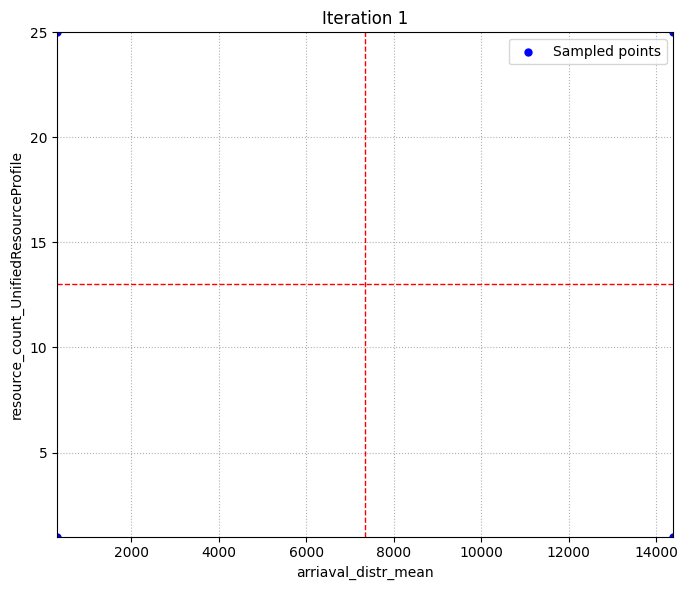



 # Evaluating corner at (300, 1)
  Target PPI List: {'lead_time': [8993124.0], 'cost': [13915.555555555557]}
  In Target Range: False, Direction: mixed


 # Evaluating corner at (7350.0, 1)
  Target PPI List: {'lead_time': [7489816.0], 'cost': [14366.666666666668]}
  In Target Range: False, Direction: mixed


 # Evaluating corner at (300, 13)
  Target PPI List: {'lead_time': [548323.0], 'cost': [14502.222222222219]}
  In Target Range: False, Direction: mixed


 # Evaluating corner at (7350.0, 13)
  Target PPI List: {'lead_time': [58184.0], 'cost': [43051.666666666664]}
  In Target Range: False, Direction: mixed
Node at depth 1 - In Range: False, Out Range: True, Direction Range Same: True
Node at depth 1 classified as out_range
 Subdividing node at depth 1...
True False


 # Evaluating corner at (7350.0, 1)
  Target PPI List: {'lead_time': [7489816.0], 'cost': [14366.666666666668]}
  In Target Range: False, Direction: mixed


 # Evaluating corner at (14400, 1)
  Target PPI List: {'le

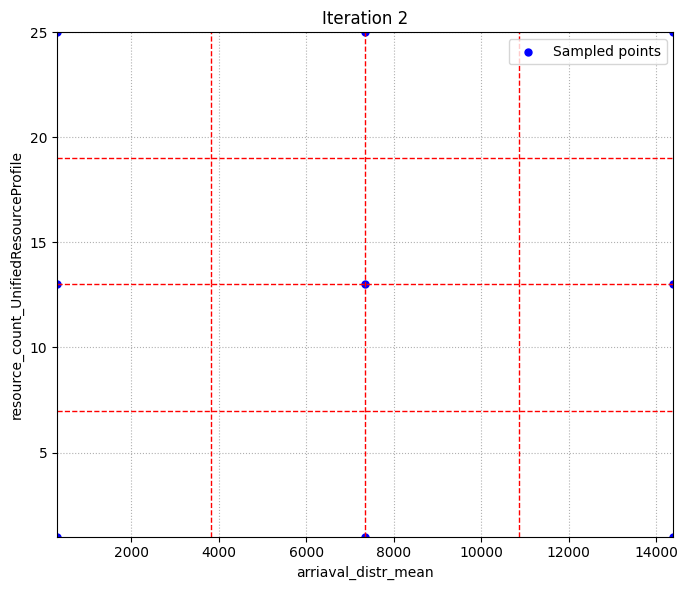



 # Evaluating corner at (300, 1)
  Target PPI List: {'lead_time': [8993124.0], 'cost': [13915.555555555557]}
  In Target Range: False, Direction: mixed


 # Evaluating corner at (3825.0, 1)
  Target PPI List: {'lead_time': [8350791.0], 'cost': [14390.0]}
  In Target Range: False, Direction: mixed


 # Evaluating corner at (300, 7)
  Target PPI List: {'lead_time': [1213575.0], 'cost': [14560.0]}
  In Target Range: False, Direction: mixed


 # Evaluating corner at (3825.0, 7)
  Target PPI List: {'lead_time': [223836.25], 'cost': [14832.22222222222]}
  In Target Range: False, Direction: mixed
Node at depth 2 - In Range: False, Out Range: True, Direction Range Same: True
Node at depth 2 classified as out_range


 # Evaluating corner at (3825.0, 1)
  Target PPI List: {'lead_time': [8350791.0], 'cost': [14390.0]}
  In Target Range: False, Direction: mixed


 # Evaluating corner at (7350.0, 1)
  Target PPI List: {'lead_time': [7489816.0], 'cost': [14366.666666666668]}
  In Target Range: Fal

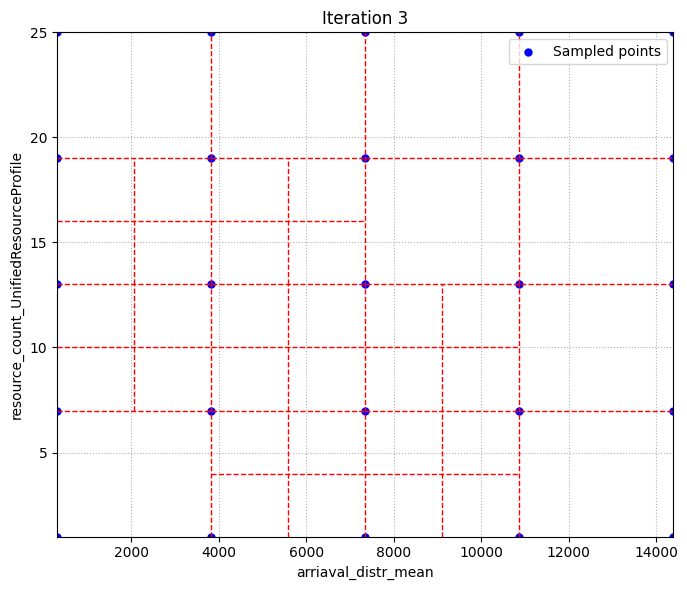



 # Evaluating corner at (3825.0, 1)
  Target PPI List: {'lead_time': [8350791.0], 'cost': [14390.0]}
  In Target Range: False, Direction: mixed


 # Evaluating corner at (5587.5, 1)
  Target PPI List: {'lead_time': [7791342.625], 'cost': [14155.555555555557]}
  In Target Range: False, Direction: mixed


 # Evaluating corner at (3825.0, 4)
  Target PPI List: {'lead_time': [1165004.25], 'cost': [14313.888888888889]}
  In Target Range: False, Direction: mixed


 # Evaluating corner at (5587.5, 4)
  Target PPI List: {'lead_time': [566216.625], 'cost': [14144.166666666668]}
  In Target Range: False, Direction: mixed
Node at depth 3 - In Range: False, Out Range: True, Direction Range Same: True
Node at depth 3 classified as out_range


 # Evaluating corner at (5587.5, 1)
  Target PPI List: {'lead_time': [7791342.625], 'cost': [14155.555555555557]}
  In Target Range: False, Direction: mixed


 # Evaluating corner at (7350.0, 1)
  Target PPI List: {'lead_time': [7489816.0], 'cost': [14366.66

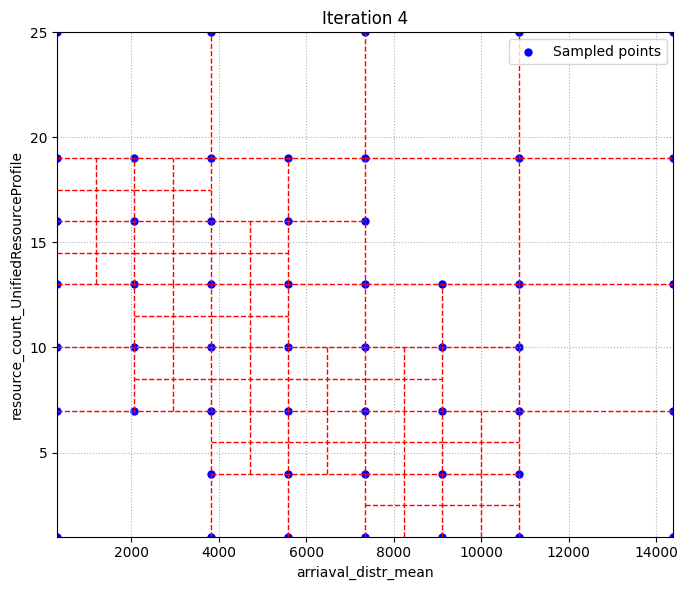



 # Evaluating corner at (3825.0, 4)
  Target PPI List: {'lead_time': [1165004.25], 'cost': [14313.888888888889]}
  In Target Range: False, Direction: mixed


 # Evaluating corner at (4706.25, 4)
  Target PPI List: {'lead_time': [841814.5], 'cost': [14193.472222222223]}
  In Target Range: False, Direction: mixed


 # Evaluating corner at (3825.0, 6)
  Target PPI List: {'lead_time': [412791.0], 'cost': [15099.999999999998]}
  In Target Range: False, Direction: mixed


 # Evaluating corner at (4706.25, 6)
  Target PPI List: {'lead_time': [181445.375], 'cost': [15343.333333333334]}
  In Target Range: False, Direction: mixed
Node at depth 4 - In Range: False, Out Range: True, Direction Range Same: True
Node at depth 4 classified as out_range


 # Evaluating corner at (4706.25, 4)
  Target PPI List: {'lead_time': [841814.5], 'cost': [14193.472222222223]}
  In Target Range: False, Direction: mixed


 # Evaluating corner at (5587.5, 4)
  Target PPI List: {'lead_time': [566216.625], 'cost': [

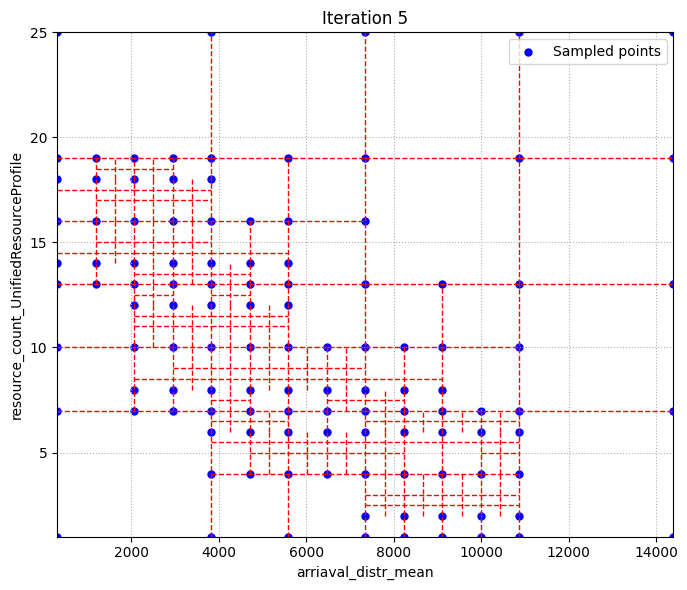

 Number of nodes: 277, Number of sampled points: 115


,algorithm,simulation_id,timestamp,target_range,status,target_ppis,target_ppi_means,target_ppi_dict,arriaval_distr_mean,resource_count_UnifiedResourceProfile
731,quadtree,731,2025-11-10T21:37:27.515290Z,"{'lead_time': [0, 82141.0], 'cost': [0, 25736.0]}",False,"[lead_time, cost]","{'lead_time': 317203.0, 'cost': 15079.99999999...","{'lead_time': [317203.0], 'cost': [15079.99999...",300.00,18
732,quadtree,732,2025-11-10T21:37:27.568125Z,"{'lead_time': [0, 82141.0], 'cost': [0, 25736.0]}",False,"[lead_time, cost]","{'lead_time': 160675.9375, 'cost': 15091.875}","{'lead_time': [160675.9375], 'cost': [15091.875]}",1181.25,18
733,quadtree,733,2025-11-10T21:37:27.626208Z,"{'lead_time': [0, 82141.0], 'cost': [0, 25736.0]}",True,"[lead_time, cost]","{'lead_time': 55320.0, 'cost': 20269.999999999...","{'lead_time': [55320.0], 'cost': [20269.999999...",2062.50,18
734,quadtree,734,2025-11-10T21:37:27.680198Z,"{'lead_time': [0, 82141.0], 'cost': [0, 25736.0]}",False,"[lead_time, cost]","{'lead_time': 117024.75, 'cost': 15859.7222222...","{'lead_time': [117024.75], 'cost': [15859.7222...",1181.25,19
735,quadtree,735,2025-11-10T21:37:27.830660Z,"{'lead_time': [0, 82141.0], 'cost': [0, 25736.0]}",False,"[lead_time, cost]","{'lead_time': 52945.1875, 'cost': 26116.249999...","{'lead_time': [52945.1875], 'cost': [26116.249...",2943.75,18
736,quadtree,736,2025-11-10T21:37:27.889996Z,"{'lead_time': [0, 82141.0], 'cost': [0, 25736.0]}",False,"[lead_time, cost]","{'lead_time': 60073.25, 'cost': 33755.0}","{'lead_time': [60073.25], 'cost': [33755.0]}",3825.00,18
737,quadtree,737,2025-11-10T21:37:27.943767Z,"{'lead_time': [0, 82141.0], 'cost': [0, 25736.0]}",False,"[lead_time, cost]","{'lead_time': 54356.25, 'cost': 27546.04166666...","{'lead_time': [54356.25], 'cost': [27546.04166...",2943.75,19
738,quadtree,738,2025-11-10T21:37:28.000632Z,"{'lead_time': [0, 82141.0], 'cost': [0, 25736.0]}",False,"[lead_time, cost]","{'lead_time': 50759.125, 'cost': 33110.9722222...","{'lead_time': [50759.125], 'cost': [33110.9722...",4706.25,14
739,quadtree,739,2025-11-10T21:37:28.058094Z,"{'lead_time': [0, 82141.0], 'cost': [0, 25736.0]}",False,"[lead_time, cost]","{'lead_time': 62424.0, 'cost': 38147.08333333334}","{'lead_time': [62424.0], 'cost': [38147.083333...",5587.50,14
740,quadtree,740,2025-11-10T21:37:28.115622Z,"{'lead_time': [0, 82141.0], 'cost': [0, 25736.0]}",False,"[lead_time, cost]","{'lead_time': 55775.125, 'cost': 37644.4444444...","{'lead_time': [55775.125], 'cost': [37644.4444...",4706.25,16


Simulation log saved to data/LoanApp_SingleRole_fixDuration/output/20251110_221801/simulation_log.csv


In [246]:
# params['print_intermediate_results'] = True
# params['in_out_criteria'] = 'confidence'
# params['nr_simulations_per_scenario'] = 3
# params['cases_to_simulate'] = 1000
# params['target_ppi'] = 'cycle_time' #'idle_cycle_time'
# params['ppi_range_factor']: 0.2
# params['execute_strategy'].append('quadtree')

if 'quadtree' in params['execute_strategy']:

    # max_depth = params['strategies']['quadtree']['max_depth']
    max_depth = 5

    # Reset the temp JSON file
    create_temp_json(input_path=params['json_path'], output_path=None)

    if __name__ == "__main__":

        # Run adaptive refinement
        frontier, quadtree_nodes, sampled_points, nodes_visited, simulation_log = adaptive_quadtree(
            set_sim_params_get_sim_stats,
            is_in_target_range, 
            params, 
            simulation_log,
            min_depth=2,
            max_depth=max_depth)

    display(simulation_log.tail(10))
    # simulation_log.to_csv(params['simulation_log_path'], index=False)
    save_simulation_log(simulation_log, params)

In [247]:
params['strategies']['quadtree']['paths'] = {}
params['strategies']['quadtree']['paths']['sampled_points'] = os.path.join(params['experiment_output_dir'], 'quadtree_sampled_points.csv')
params['strategies']['quadtree']['paths']['nodes_visited'] = os.path.join(params['experiment_output_dir'], 'quadtree_nodes_visited.csv')


In [248]:
import csv

def write_quadtree_nodes_to_file(quadtree_nodes, params):
    """
    Write the quadtree nodes to a CSV file.

    Args:
        quadtree_nodes (list[QuadNode]): List of quadtree nodes.
        params (dict): Simulation pipeline parameters containing output file path.
    Returns:
        None
    """
    output_file_path = params['strategies']['quadtree']['paths']['sampled_points']

    # Define the header for the CSV file
    header = ["x_min", "x_max", "y_min", "y_max", "depth", "is_leaf", "status"]

    # Open the file for writing
    with open(output_file_path, mode="w", newline="") as file:
        writer = csv.DictWriter(file, fieldnames=header)
        
        # Write the header
        writer.writeheader()
        
        # Write each node's properties
        for node in quadtree_nodes:
            writer.writerow({
                "x_min": node.x_min,
                "x_max": node.x_max,
                "y_min": node.y_min,
                "y_max": node.y_max,
                "depth": node.depth,
                "is_leaf": node.is_leaf,
                "status": node.status,
            })

    print(f"Quadtree nodes written to {output_file_path}")

In [249]:
import json

def write_nodes_visited_to_json(nodes_visited, params):
    """
    Write the nodes_visited dictionary to a JSON file.

    Args:
        nodes_visited (dict): Dictionary containing nodes visited and sampled points at each depth level.
        output_file (str): Path to the output JSON file.

    Returns:
        None
    """
    output_file = params['strategies']['quadtree']['paths']['nodes_visited']
    with open(output_file, "w") as file:
        json.dump(nodes_visited, file, indent=4)  # Use indent=4 for pretty formatting
    print(f"Nodes visited written to {output_file}")

In [250]:

def read_quadtree_nodes_from_file(input_file):
    """
    Read quadtree nodes from a CSV file and return them as a list of QuadNode objects.

    Args:
        input_file (str): Path to the input CSV file.

    Returns:
        list[QuadNode]: List of QuadNode objects.
    """
    quadtree_nodes = []

    # Open the file for reading
    with open(input_file, mode="r") as file:
        reader = csv.DictReader(file)
        
        # Read each row and create a QuadNode object
        for row in reader:
            quadtree_nodes.append(
                QuadNode(
                    x_min=float(row["x_min"]),
                    x_max=float(row["x_max"]),
                    y_min=float(row["y_min"]),
                    y_max=float(row["y_max"]),
                    depth=int(row["depth"]),
                    is_leaf=row["is_leaf"] == "True",  # Convert string to boolean
                    status=row["status"],
                )
            )

    print(f"Quadtree nodes read from {input_file}")
    return quadtree_nodes

In [251]:
def read_nodes_visited_from_json(input_file):
    """
    Read the nodes_visited data from a JSON file and return it as a dictionary.

    Args:
        input_file (str): Path to the input JSON file.

    Returns:
        dict: Dictionary containing nodes visited and sampled points at each depth level.
    """
    with open(input_file, "r") as file:
        nodes_visited = json.load(file)
    print(f"Nodes visited read from {input_file}")
    return nodes_visited

In [252]:
if 'quadtree' in params['execute_strategy']:
    write_quadtree_nodes_to_file(quadtree_nodes, params)
    write_nodes_visited_to_json(nodes_visited, params)
    save_params(params)

Quadtree nodes written to data/LoanApp_SingleRole_fixDuration/output/20251110_221801/quadtree_sampled_points.csv
Nodes visited written to data/LoanApp_SingleRole_fixDuration/output/20251110_221801/quadtree_nodes_visited.csv
Parameters saved to data/LoanApp_SingleRole_fixDuration/output/20251110_221801/params.json


## 3. Evaluation


###### Second try

In [ ]:
import numpy as np
import pandas as pd

def evaluate_quadtree_vs_simulation_log(all_nodes, simulation_log, params, depth_level):
    """
    Evaluate how many ground-truth grid points (from simulation_log) fall inside
    in_range vs out_range quadtree nodes, up to a given depth level.
    Also reports how many grid points remain unclassified (not covered by any
    in_range or out_range node), and how many nodes were visited and computed.

    Parameters
    ----------
    all_nodes : list[QuadNode]
        All nodes from the quadtree. Each node must have: 
        x_min, x_max, y_min, y_max, depth, is_leaf, status.
    simulation_log : pd.DataFrame
        DataFrame containing at least:
            - param_x, param_y : grid search coordinates
            - status : True (in-range) or False (out-of-range)
    params : dict
        Contains 'params_to_change' with two parameters being varied.
    depth_level : int
        Only consider quadtree nodes up to this depth.

    Returns
    -------
    results_df : pd.DataFrame
        Per-node statistics.
    summary : pd.Series
        Aggregated counts including number of unclassified grid points,
        nodes visited, and nodes computed.
    """


    # Determine which parameter names correspond to X and Y
    param_x, param_y = list(params['params_to_change'].keys())

    # Keep only grid search entries
    simulation_log = simulation_log[simulation_log['algorithm'] == 'grid_search'].copy()

    # Extract numpy arrays for faster computation
    grid_x = simulation_log[param_x].to_numpy()
    grid_y = simulation_log[param_y].to_numpy()
    grid_status = simulation_log['status'].astype(bool).to_numpy()
    total_points = len(simulation_log)

    counted_indices = set()
    results = []

    # Initialize counters for visited and computed nodes
    nodes_visited = 0
    nodes_computed = 0

    for node in all_nodes:
        # Count the node as visited if it is within the depth level
        if node.depth <= depth_level:
            nodes_visited += 1

        # Only process leaf nodes up to target depth
        if not node.is_leaf or node.depth > depth_level:
            continue

        # Count the node as computed if it is a leaf node at the depth level
        nodes_computed += 1

        if node.status not in ("in_range", "out_range"):
            # Skip mixed or undefined nodes when classifying points
            continue

        x_min, x_max, y_min, y_max = node.x_min, node.x_max, node.y_min, node.y_max

        # Identify points inside this node
        inside_mask = (
            (grid_x >= x_min) &
            (grid_x <= x_max) &
            (grid_y >= y_min) &
            (grid_y <= y_max)
        )
        inside_indices = np.where(inside_mask)[0]

        # Remove duplicates (points already counted)
        new_indices = [i for i in inside_indices if i not in counted_indices]
        counted_indices.update(new_indices)
        new_indices = np.array(new_indices)

        # Count how many are True vs False in the ground truth
        if len(new_indices) > 0:
            in_true = np.sum(grid_status[new_indices])
            out_true = len(new_indices) - in_true
        else:
            in_true = out_true = 0

        results.append({
            "depth": node.depth,
            "status": node.status,
            "x_min": x_min,
            "x_max": x_max,
            "y_min": y_min,
            "y_max": y_max,
            "n_points_total": len(new_indices),
            "n_points_true_inrange": in_true,
            "n_points_true_outrange": out_true,
        })

    results_df = pd.DataFrame(results)

    # ---- Aggregate summary ----
    # handle case of empty results_df
    if results_df.empty:
        results_df = pd.DataFrame(columns=[
            "depth", "status", "x_min", "x_max", "y_min", "y_max",
            "n_points_total", "n_points_true_inrange", "n_points_true_outrange"
        ])
    
    total_in_nodes = np.sum(results_df["status"] == "in_range")
    total_out_nodes = np.sum(results_df["status"] == "out_range")

    points_in_inrange_nodes = int(results_df.loc[results_df["status"] == "in_range", "n_points_total"].sum())
    points_in_outrange_nodes = int(results_df.loc[results_df["status"] == "out_range", "n_points_total"].sum())

    unique_points_classified = len(counted_indices)
    unclassified_points = total_points - unique_points_classified

    # Get the unclassified points
    unclassified_indices = [i for i in range(total_points) if i not in counted_indices]
    unclassified_points_df = simulation_log.iloc[unclassified_indices][[param_x, param_y]]


    summary = {
        "depth_level": depth_level,
        "total_nodes": len(results_df),
        "in_range_nodes": total_in_nodes,
        "out_range_nodes": total_out_nodes,
        "points_in_inrange_nodes": points_in_inrange_nodes,
        "points_in_outrange_nodes": points_in_outrange_nodes,
        "unique_points_classified": unique_points_classified,
        "unclassified_points": unclassified_points,
        "fraction_inrange_nodes_points": (
            results_df.loc[results_df["status"] == "in_range", "n_points_true_inrange"].sum() / total_points
            if total_points > 0 else 0
        ),
        "fraction_outrange_nodes_points": (
            results_df.loc[results_df["status"] == "out_range", "n_points_true_outrange"].sum() / total_points
            if total_points > 0 else 0
        ),
        "fraction_unclassified_points": (
            unclassified_points / total_points if total_points > 0 else 0
        ),
        "nodes_visited": nodes_visited,  # Total nodes visited at this depth
        "nodes_computed": nodes_computed,  # Total nodes computed at this depth
    }

    # display(unclassified_points_df)

    return results_df, pd.Series(summary)

In [313]:
import pandas as pd
import numpy as np

def compute_quadtree_metrics(results_df, summary):
    """
    Compute precision, recall, and accuracy for quadtree classification
    against the ground truth (simulation_log), based on output from
    `evaluate_quadtree_vs_simulation_log`.

    Parameters
    ----------
    results_df : pd.DataFrame
        Output DataFrame from evaluate_quadtree_vs_simulation_log, containing:
          - status (in_range / out_range)
          - n_points_true_inrange
          - n_points_true_outrange
    summary : pd.Series
        Summary output including total_points or unclassified counts.

    Returns
    -------
    pd.Series
        Metrics including precision, recall, accuracy, and unclassified fraction.
    """

    # --- Count confusion matrix elements ---
    TP = results_df.loc[results_df["status"] == "in_range", "n_points_true_inrange"].sum()
    FP = results_df.loc[results_df["status"] == "in_range", "n_points_true_outrange"].sum()
    TN = results_df.loc[results_df["status"] == "out_range", "n_points_true_outrange"].sum()
    FN = results_df.loc[results_df["status"] == "out_range", "n_points_true_inrange"].sum()

    total_classified = TP + FP + TN + FN
    total_points = summary.get("unique_points_classified", total_classified) + summary.get("unclassified_points", 0)

    # --- Metrics ---
    precision = TP / (TP + FP) if (TP + FP) > 0 else np.nan
    recall = TP / (TP + FN) if (TP + FN) > 0 else np.nan
    accuracy = (TP + TN) / total_classified if total_classified > 0 else np.nan
    mcc = (
        (TP * TN - FP * FN) /
        np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
        if (TP + FP) > 0 and (TP + FN) > 0 and (TN + FP) > 0 and (TN + FN) > 0 else np.nan
    )

    unclassified_fraction = (
        summary.get("unclassified_points", 0) / total_points if total_points > 0 else np.nan
    )

    return pd.Series({
        "TP": int(TP),
        "FP": int(FP),
        "TN": int(TN),
        "FN": int(FN),
        "precision_inrange": precision,
        "recall_inrange": recall,
        "accuracy": accuracy,
        "mcc": mcc,
        "unclassified_fraction": unclassified_fraction,
        "total_points": int(total_points),
        "classified_points": int(total_classified),
        "unclassified_points": int(summary.get("unclassified_points", 0)),
    })


In [314]:
# Assuming your simulation_log DataFrame has 'param_x' and 'param_y'
results_df, summary = evaluate_quadtree_vs_simulation_log(quadtree_nodes, simulation_log, params, depth_level=1)

print(summary)

# Optional: inspect detailed per-node results
display(results_df.head(10))

Length of all nodes: 277
depth_level                         1.0
total_nodes                         0.0
in_range_nodes                      0.0
out_range_nodes                     0.0
points_in_inrange_nodes             0.0
points_in_outrange_nodes            0.0
unique_points_classified            0.0
unclassified_points               625.0
fraction_inrange_nodes_points       0.0
fraction_outrange_nodes_points      0.0
fraction_unclassified_points        1.0
nodes_visited                       5.0
nodes_computed                      0.0
dtype: float64


,depth,status,x_min,x_max,y_min,y_max,n_points_total,n_points_true_inrange,n_points_true_outrange


In [315]:
quadtree_nodes[0].depth

0

In [316]:
results_df, summary = evaluate_quadtree_vs_simulation_log(quadtree_nodes, simulation_log, params, depth_level=5)
metrics = compute_quadtree_metrics(results_df, summary)
print(metrics)


Length of all nodes: 277
TP                        25.000000
FP                         0.000000
TN                       518.000000
FN                        24.000000
precision_inrange          1.000000
recall_inrange             0.510204
accuracy                   0.957672
mcc                        0.698292
unclassified_fraction      0.092800
total_points             625.000000
classified_points        567.000000
unclassified_points       58.000000
dtype: float64


In [317]:
def plot_quadtree_metrics_over_depth(quadtree_nodes, simulation_log, params, max_depth, metric="accuracy"):
    """
    Plots quadtree metrics (accuracy, precision, or recall) and the fraction of classified points
    over the depth levels of the quadtree.

    Args:
        all_nodes (list[QuadNode]): All nodes from the quadtree.
        simulation_log (pd.DataFrame): DataFrame containing ground-truth grid points.
        params (dict): Contains 'params_to_change' with two parameters being varied.
        max_depth (int): Maximum depth level to evaluate.
        metric (str): The metric to plot on the left y-axis. Options: "accuracy", "precision", "recall".

    Returns:
        None
    """
    # Initialize lists to store metrics for each depth level
    depths = []
    metric_values = []
    fractions_classified = []

    # Map the metric argument to the correct key in the metrics object
    metric_key_map = {
        "accuracy": "accuracy",
        "mcc": "mcc",
        "precision": "precision_inrange",
        "recall": "recall_inrange"
    }
    if metric not in metric_key_map:
        raise ValueError("Invalid metric. Choose from 'accuracy', 'precision', or 'recall'.")

    metric_key = metric_key_map[metric]

    # Iterate over depth levels
    for depth in range(1, max_depth + 1):
        # Evaluate the quadtree at the current depth level
        results_df, summary = evaluate_quadtree_vs_simulation_log(quadtree_nodes, simulation_log, params, depth)

        # Compute metrics for the current depth level
        metrics = compute_quadtree_metrics(results_df, summary)

        # Append depth and metrics
        depths.append(depth)
        metric_values.append(metrics[metric_key])  # Use the correct key for the selected metric
        fractions_classified.append(1 - metrics["unclassified_fraction"])  # Fraction classified

    # Plot the metrics
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot the selected metric on the left y-axis
    ax1.set_xlabel("Tree Depth Level")
    ax1.set_ylabel(metric.capitalize(), color="tab:blue")
    ax1.plot(depths, metric_values, label=metric.capitalize(), color="tab:blue", marker="o")
    ax1.set_ylim(0, 1)
    ax1.tick_params(axis="y", labelcolor="tab:blue")

    # Plot the fraction of classified points on the right y-axis
    ax2 = ax1.twinx()
    ax2.set_ylim(0, 1)
    ax2.set_ylabel("Fraction of Classified Points", color="tab:orange")
    ax2.plot(depths, fractions_classified, label="Fraction Classified", color="tab:orange", marker="x")
    ax2.tick_params(axis="y", labelcolor="tab:orange")

    # Add a title and legend
    fig.suptitle(f"Quadtree Metrics vs Depth (Metric: {metric.capitalize()})", fontsize=14)
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")

    # Show the plot
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.savefig(os.path.join(params['experiment_output_dir'], f'quadtree_{metric}_vs_depth.png'))
    plt.show()

In [318]:
simulation_log.tail(2)

,algorithm,simulation_id,timestamp,target_range,status,target_ppis,target_ppi_means,target_ppi_dict,arriaval_distr_mean,resource_count_UnifiedResourceProfile
739,quadtree,739,2025-11-10T21:37:28.058094Z,"{'lead_time': [0, 82141.0], 'cost': [0, 25736.0]}",False,"[lead_time, cost]","{'lead_time': 62424.0, 'cost': 38147.08333333334}","{'lead_time': [62424.0], 'cost': [38147.083333...",5587.50,14
740,quadtree,740,2025-11-10T21:37:28.115622Z,"{'lead_time': [0, 82141.0], 'cost': [0, 25736.0]}",False,"[lead_time, cost]","{'lead_time': 55775.125, 'cost': 37644.4444444...","{'lead_time': [55775.125], 'cost': [37644.4444...",4706.25,16


In [319]:
import matplotlib.pyplot as plt

def generate_and_plot_quadtree_metrics(quadtree_nodes, simulation_log, params, max_depth, nodes_visited):
    """
    Generate quadtree metrics for each depth level and plot the required metrics.

    Args:
        quadtree_nodes (list[QuadNode]): All nodes from the quadtree.
        simulation_log (pd.DataFrame): DataFrame containing grid search points.
        params (dict): Contains 'params_to_change' with two parameters being varied.
        max_depth (int): Maximum depth level to evaluate.
        nodes_visited (dict): Dictionary containing the number of nodes visited and evaluated at each depth.

    Returns:
        None
    """
    # Initialize lists to store metrics
    quadtree_metrics = []

    # Generate metrics for each depth level
    for depth in range(1, max_depth + 1):
        # depth += 1
        results_df, summary = evaluate_quadtree_vs_simulation_log(quadtree_nodes, simulation_log, params, depth)
        metrics = compute_quadtree_metrics(results_df, summary)
        quadtree_metrics.append(metrics)

    # Extract depth levels from nodes_visited
    # depth_levels = list(nodes_visited.keys())

    depth_levels = [d for d in range(1, max_depth + 1)]

    # Extract metrics for plotting
    grid_search_points = len(simulation_log[simulation_log['algorithm'] == 'grid_search'])  # Total number of grid search points (horizontal line)
    classified_points = [
        metrics["classified_points"] for metrics in quadtree_metrics
    ]  # Absolute number of classified points
    all_nodes_visited = [nodes_visited[depth-1]["all_nodeds"] for depth in depth_levels]  # All nodes visited
    sampled_points =    [nodes_visited[depth-1]["sampled_points"] for depth in depth_levels]  # Evaluated points

    # Plot the metrics
    plt.figure(figsize=(10, 6))

    # Horizontal line for grid search points
    plt.axhline(y=grid_search_points, color="tab:blue", linestyle="--", label="Grid Search Points (Total)")

    # Absolute number of classified points
    plt.plot(
        depth_levels,
        classified_points,
        label="Classified Points",
        color="tab:orange",
        marker="o",
    )

    # # All nodes visited
    # plt.plot(
    #     depth_levels,
    #     all_nodes_visited,
    #     label="All Nodes Visited",
    #     color="tab:green",
    #     marker="s",
    # )

    # Evaluated points
    plt.plot(
        depth_levels,
        sampled_points,
        label="Evaluated Points",
        color="tab:red",
        marker="x",
    )

    # Add labels, legend, and title
    plt.xlabel("Tree Depth Level", fontsize=12)
    plt.ylabel("Number of Parameter Settings", fontsize=12)
    plt.title("Quadtree Evaluation Metrics vs Tree Depth Level", fontsize=14)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.savefig(os.path.join(params['experiment_output_dir'], 'quadtree_evaluation_metrics.png'))

    # Show the plot
    plt.show()

Length of all nodes: 277
Length of all nodes: 277
Length of all nodes: 277
Length of all nodes: 277
Length of all nodes: 277


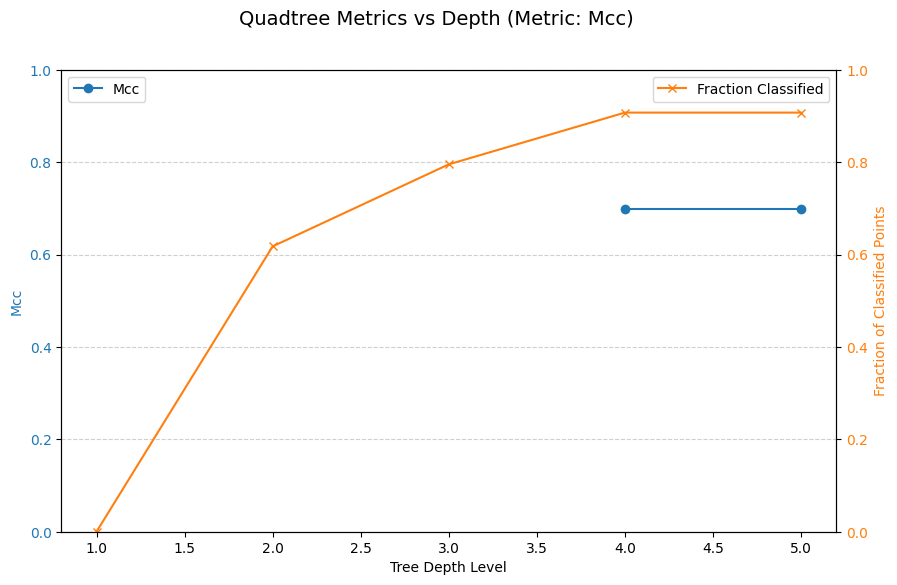

In [320]:
#  Call the function
plot_quadtree_metrics_over_depth(quadtree_nodes, simulation_log, params, max_depth=max_depth, metric="mcc")

Length of all nodes: 277
Length of all nodes: 277
Length of all nodes: 277
Length of all nodes: 277
Length of all nodes: 277


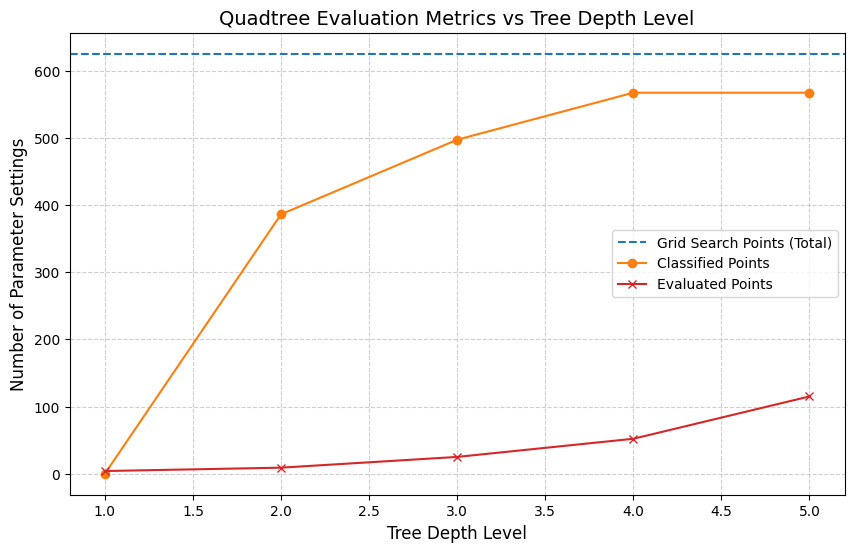

In [321]:
# Call the function
generate_and_plot_quadtree_metrics(quadtree_nodes, simulation_log, params, max_depth=max_depth, nodes_visited=nodes_visited)

In [322]:
evaluate_quadtree_vs_simulation_log(quadtree_nodes, simulation_log, params, 1)

Length of all nodes: 277


(Empty DataFrame
 Columns: [depth, status, x_min, x_max, y_min, y_max, n_points_total, n_points_true_inrange, n_points_true_outrange]
 Index: [],
 depth_level                         1.0
 total_nodes                         0.0
 in_range_nodes                      0.0
 out_range_nodes                     0.0
 points_in_inrange_nodes             0.0
 points_in_outrange_nodes            0.0
 unique_points_classified            0.0
 unclassified_points               625.0
 fraction_inrange_nodes_points       0.0
 fraction_outrange_nodes_points      0.0
 fraction_unclassified_points        1.0
 nodes_visited                       5.0
 nodes_computed                      0.0
 dtype: float64)

###### Testing

In [323]:
# frontier, quadtree_nodes, sampled_points
for node in quadtree_nodes[:10]:
    # print(node.x_min, node.x_max, node.y_min, node.y_max, getattr(node, "in_range", False))
    if getattr(node, "in_range", True):
        print(node.x_min, node.x_max, node.y_min, node.y_max, node.depth, len(node.children), node.is_leaf, node.status)#, node.corner_results)
        # print(node)

300 14400 1 25 0 4 False out_range
300 7350.0 1 13 1 4 False out_range
7350.0 14400 1 13 1 4 False out_range
300 7350.0 13 25 1 4 False out_range
7350.0 14400 13 25 1 4 False out_range
300 3825.0 1 7 2 0 True out_range
3825.0 7350.0 1 7 2 4 False mixed
300 3825.0 7 13 2 4 False mixed
3825.0 7350.0 7 13 2 4 False mixed
7350.0 10875.0 1 7 2 4 False mixed


In [324]:

# ### Test

# # display simulation log filtered for grid search runs
# display(simulation_log[simulation_log['algorithm'] == 'grid_search'].head(5))

# # set the status of this point to False
# # 18	grid_search	18	2025-10-27T09:33:42.395579Z	[53841.0, 80762.0]	True	idle_cycle_time	67473.913645	[66621.54710605, 67106.30869354002, 68693.8851...	10875.0	13
# # simulation_log.loc[18, 'status'] = False

# # Assuming your simulation_log DataFrame has 'param_x' and 'param_y'
# results_df, summary = evaluate_quadtree_vs_simulation_log(quadtree_nodes, simulation_log, params, depth_level=2)

# print(summary)

# # Optional: inspect detailed per-node results
# display(results_df.head(10))


### Old works

**Simulation Input: Parameters**

- \( x_1, x_2, x_3 \)

**Simulation Output:**

- \( y = f(x_1, x_2, x_3) \)

**Goal:** 

- Find \( x \) such that \( y_{\text{low}} \leq f(x) \leq y_{\text{high}} \)


<strong>Simulation Input: Parameters</strong>

<ul>
  <li>x<sub>1</sub>, x<sub>2</sub>, x<sub>3</sub></li>
</ul>

<strong>Simulation Output:</strong>

<ul>
  <li>y = f(x<sub>1</sub>, x<sub>2</sub>, x<sub>3</sub>)</li>
</ul>

<strong>Goal:</strong>

<ul>
  <li>Find x such that y<sup>low</sup> &le; f(x) &le; y<sup>high</sup></li>
</ul>

#### External Library

In [ ]:
# %pip install scipy

In [ ]:
from scipy.optimize import brentq
import numpy as np

def is_ppi_within_target(ppi, target_range):
    return target_range[0] <= ppi <= target_range[1]

def make_ppi_constraint_function(simulate_func, target_range):
    """Returns a function that is negative inside safe zone and positive outside."""
    def constraint_func(x):
        ppi = simulate_func(x)
        # print(f"Testing {x} → PPI: {ppi}")
        if is_ppi_within_target(ppi, target_range):
            return -1  # safe
        else:
            return 1   # unsafe
    return constraint_func

def find_safe_bounds_brentq(simulate_func, baseline_value, domain_min, domain_max, target_range):
    constraint_func = make_ppi_constraint_function(simulate_func, target_range)
    bounds = [baseline_value, baseline_value]

    # Search upper bound
    try:
        upper = brentq(constraint_func, baseline_value, domain_max)
        bounds[1] = upper
    except ValueError:
        # No crossing → assume safe until domain_max
        bounds[1] = domain_max

    # Search lower bound
    try:
        lower = brentq(constraint_func, domain_min, baseline_value)
        bounds[0] = lower
    except ValueError:
        # No crossing → assume safe until domain_min
        bounds[0] = domain_min

    return bounds


In [ ]:
def run_simulation_with_param(param_value):
    # A fake PPI function (in practice this calls your simulation engine)
    # Assume PPI gets worse (higher) as param_value increases
    return 3.0 + 0.002 * (param_value - 3600)


In [ ]:
baseline = 3600
domain_min = 3000
domain_max = 5000
target_range = [0, 5]  # PPI must be ≤ 5

safe_bounds = find_safe_bounds_brentq(get_simulation_stats,
                                       baseline,
                                       domain_min,
                                       domain_max,
                                       target_range)

print(f"Safe bounds for param: {safe_bounds} seconds")
print(f"Safe bounds in hours: [{safe_bounds[0]/3600:.2f}, {safe_bounds[1]/3600:.2f}] hrs")


### 3. Semi-factual statements

Output:
- For all involved simulation parameters that can be changed:
    - Show tha Maximum range it can be changed from all the possible found solutions
    - In an interactive fashion, the user can choose to change a first parameter and based on that change, all other parameter changes in their range
